Hi there, this notebook aims to provide visualization about different features distribution and observing abnormal values in the dataset. 

# Table of Contents
1. Target Distribution
2. application_{train|test}.csv
    * 2.1 NaN Count
    * 2.2 [Feature Generation] Adding IS_NAN features for each column.
    * 2.3 The importance of the missing values
    * 2.4. Features' Distribution
    * 2.5 Are the distributions making sense?
3. bureau.csv
4. ...pending

# 1. Target Distribution




In [5]:
from IPython.display import HTML
import pandas as pd
import matplotlib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import collections
from lightgbm import LGBMClassifier, plot_importance
import seaborn as snss
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 200})
%matplotlib inline
inputFile = 'C:\\Users\\momar\\OneDrive - Queen Mary, University of London\\MSc Project\\Home Credit Data'
train_application_df = pd.read_csv(inputFile + '\\application_train.csv')
test_application_df = pd.read_csv(inputFile + '\\application_test.csv')
# print(train_application_df.shape, test_application_df.shape)
all_application_df = pd.concat([train_application_df, test_application_df], axis=0, sort=True)
# print(all_application_df.shape)

The target distribution is imbalanced, which indicates the company has already done a great job (some direct feature, like external scoring, in the dataset might not be that helpful)

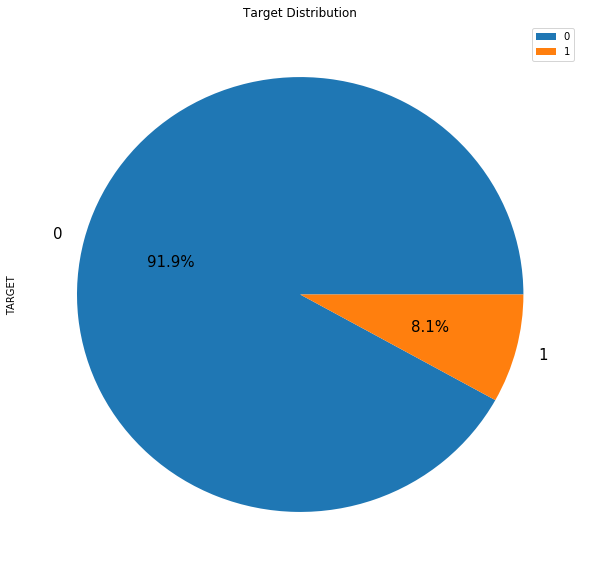

In [6]:
target_distribution = train_application_df['TARGET'].value_counts()
target_distribution.plot.pie(figsize=(10, 10),
                             title='Target Distribution',
                             fontsize=15, 
                             legend=True, 
                             autopct=lambda v: "{:0.1f}%".format(v))

# 2. application_{train|test}.csv> 
##  2.1 NaN Count
There are lots of NaN values in the dataset (also as discussed in the forum, the organizer also filled in some missing data with magic values). Need to handle them carefully.

In [7]:
total_nans = all_application_df.isna().sum()
nan_precents = (all_application_df.isna().sum()/all_application_df.isna().count()*100)
feature_overview_df  = pd.concat([total_nans, nan_precents], axis=1, keys=['NaN Count', 'NaN Pencent'])
feature_overview_df['Type'] = [all_application_df[c].dtype for c in feature_overview_df.index]
pd.set_option('display.max_rows', None)
display(feature_overview_df)
pd.set_option('display.max_rows', 20)

NaN Count  NaN Pencent     Type
AMT_ANNUITY                          36     0.010105  float64
AMT_CREDIT                            0     0.000000  float64
AMT_GOODS_PRICE                     278     0.078034  float64
AMT_INCOME_TOTAL                      0     0.000000  float64
AMT_REQ_CREDIT_BUREAU_DAY         47568    13.352234  float64
AMT_REQ_CREDIT_BUREAU_HOUR        47568    13.352234  float64
AMT_REQ_CREDIT_BUREAU_MON         47568    13.352234  float64
AMT_REQ_CREDIT_BUREAU_QRT         47568    13.352234  float64
AMT_REQ_CREDIT_BUREAU_WEEK        47568    13.352234  float64
AMT_REQ_CREDIT_BUREAU_YEAR        47568    13.352234  float64
APARTMENTS_AVG                   179948    50.511010  float64
APARTMENTS_MEDI                  179948    50.511010  float64
APARTMENTS_MODE                  179948    50.511010  float64
BASEMENTAREA_AVG                 207584    58.268375  float64
BASEMENTAREA_MEDI                207584    58.268375  float64
BASEMENTAREA_MODE                207584    58.268375  float64
CNT_CHILDREN                          0     0.000000    int64
CNT_FAM_MEMBERS                       2     0.000561  float64
CODE_GENDER                           0     0.000000   object
COMMONAREA_AVG                   248360    69.714109  float64
COMMONAREA_MEDI                  248360    69.714109  float64
COMMONAREA_MODE                  248360    69.714109  float64
DAYS_BIRTH                            0     0.000000    int64
DAYS_EMPLOYED                         0     0.000000    int64
DAYS_ID_PUBLISH                       0     0.000000    int64
DAYS_LAST_PHONE_CHANGE                1     0.000281  float64
DAYS_REGISTRATION                     0     0.000000  float64
DEF_30_CNT_SOCIAL_CIRCLE           1050     0.294733  float64
DEF_60_CNT_SOCIAL_CIRCLE           1050     0.294733  float64
ELEVATORS_AVG                    189080    53.074343  float64
ELEVATORS_MEDI                   189080    53.074343  float64
ELEVATORS_MODE                   189080    53.074343  float64
EMERGENCYSTATE_MODE              167964    47.147128   object
ENTRANCES_AVG                    178407    50.078455  float64
ENTRANCES_MEDI                   178407    50.078455  float64
ENTRANCES_MODE                   178407    50.078455  float64
EXT_SOURCE_1                     193910    54.430113  float64
EXT_SOURCE_2                        668     0.187506  float64
EXT_SOURCE_3                      69633    19.545831  float64
FLAG_CONT_MOBILE                      0     0.000000    int64
FLAG_DOCUMENT_10                      0     0.000000    int64
FLAG_DOCUMENT_11                      0     0.000000    int64
FLAG_DOCUMENT_12                      0     0.000000    int64
FLAG_DOCUMENT_13                      0     0.000000    int64
FLAG_DOCUMENT_14                      0     0.000000    int64
FLAG_DOCUMENT_15                      0     0.000000    int64
FLAG_DOCUMENT_16                      0     0.000000    int64
FLAG_DOCUMENT_17                      0     0.000000    int64
FLAG_DOCUMENT_18                      0     0.000000    int64
FLAG_DOCUMENT_19                      0     0.000000    int64
FLAG_DOCUMENT_2                       0     0.000000    int64
FLAG_DOCUMENT_20                      0     0.000000    int64
FLAG_DOCUMENT_21                      0     0.000000    int64
FLAG_DOCUMENT_3                       0     0.000000    int64
FLAG_DOCUMENT_4                       0     0.000000    int64
FLAG_DOCUMENT_5                       0     0.000000    int64
FLAG_DOCUMENT_6                       0     0.000000    int64
FLAG_DOCUMENT_7                       0     0.000000    int64
FLAG_DOCUMENT_8                       0     0.000000    int64
FLAG_DOCUMENT_9                       0     0.000000    int64
FLAG_EMAIL                            0     0.000000    int64
FLAG_EMP_PHONE                        0     0.000000    int64
FLAG_MOBIL                            0     0.000000    int64
FLAG_OWN_CAR                          0     0.000000   object


## 2.2 [Feature Generation] Adding IS_NAN features for each column.

In [8]:
all_application_is_nan_df = pd.DataFrame()
for column in all_application_df.columns:
    if all_application_df[column].isna().sum() == 0:
        continue
    all_application_is_nan_df['is_nan_'+column] = all_application_df[column].isna()
    all_application_is_nan_df['is_nan_'+column] = all_application_is_nan_df['is_nan_'+column].map(lambda v: 1 if v else 0)
all_application_is_nan_df['target'] = all_application_df['TARGET']
all_application_is_nan_df = all_application_is_nan_df[pd.notna(all_application_is_nan_df['target'])]

In [9]:
display(all_application_is_nan_df)

is_nan_AMT_ANNUITY  is_nan_AMT_GOODS_PRICE  \
0                        0                       0   
1                        0                       0   
2                        0                       0   
3                        0                       0   
4                        0                       0   
5                        0                       0   
6                        0                       0   
7                        0                       0   
8                        0                       0   
9                        0                       0   
...                    ...                     ...   
307501                   0                       0   
307502                   0                       0   
307503                   0                       0   
307504                   0                       0   
307505                   0                       0   
307506                   0                       0   
307507                   0                       0   
307508                   0                       0   
307509                   0                       0   
307510                   0                       0   

        is_nan_AMT_REQ_CREDIT_BUREAU_DAY  is_nan_AMT_REQ_CREDIT_BUREAU_HOUR  \
0                                      0                                  0   
1                                      0                                  0   
2                                      0                                  0   
3                                      1                                  1   
4                                      0                                  0   
5                                      0                                  0   
6                                      0                                  0   
7                                      0                                  0   
8                                      0                                  0   
9                                      1                                  1   
...                                  ...                                ...   
307501                                 1                                  1   
307502                                 0                                  0   
307503                                 0                                  0   
307504                                 1                                  1   
307505                                 0                                  0   
307506                                 1                                  1   
307507                                 1                                  1   
307508                                 0                                  0   
307509                                 0                                  0   
307510                                 0                                  0   

        is_nan_AMT_REQ_CREDIT_BUREAU_MON  is_nan_AMT_REQ_CREDIT_BUREAU_QRT  \
0                                      0                                 0   
1                                      0                                 0   
2                                      0                                 0   
3                                      1                                 1   
4                                      0                                 0   
5                                      0                                 0   
6                                      0                                 0   
7                                      0                                 0   
8                                      0                                 0   
9                                      1                                 1   
...                                  ...                               ...   
307501                                 1                                 1   
307502                                 0                          

## 2.3 The importance of the missing values

In [10]:
Y = all_application_is_nan_df.pop('target')
X = all_application_is_nan_df

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.2, random_state=2018)

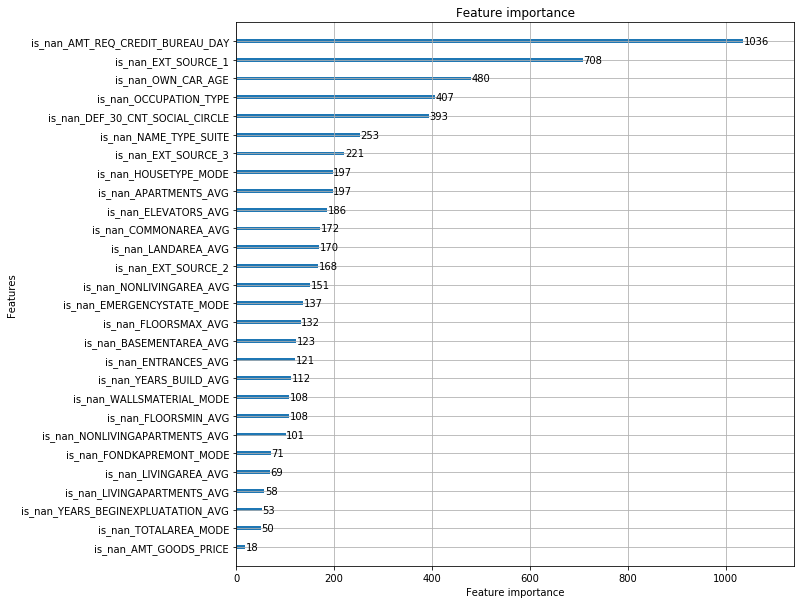

In [11]:
clf = LGBMClassifier(n_estimators=200, learning_rate=0.01)
clf.fit(
        train_X,
        train_Y,
        eval_set=[(train_X, train_Y), (valid_X, valid_Y)],
        eval_metric='auc',
        early_stopping_rounds=50,
        verbose=False
       )
plot_importance(clf, figsize=(10,10))

## 2.4 Features' Distribution

In [39]:
# add noise to y axis to avoid overlapping
def rand_jitter(arr):
    nosie = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr))

def draw_feature_distribution(df, column, fileName = ''):
    column_values = df[df[column].notna()][column]
    # group by target
    class_0_values = df[df[column].notna() & (df['TARGET']==0)][column]
    class_1_values = df[df[column].notna() & (df['TARGET']==1)][column]
    class_t_values = df[df[column].notna() & (df['TARGET'].isna())][column]        
    print('\n\n', column)
    # for features with unique values >= 10
    if len(df[column].value_counts().keys()) >= 10:
        fig, ax = plt.subplots(1, figsize=(15, 4))
        if df[column].dtype == 'object':
            label_encoder = LabelEncoder()
            label_encoder.fit(column_values)
            class_0_values = label_encoder.transform(class_0_values)
            class_1_values = label_encoder.transform(class_1_values)
            class_t_values = label_encoder.transform(class_t_values)
            column_values = label_encoder.transform(column_values)
            plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_, fontsize=12, rotation='vertical')

        ax.scatter(class_0_values, rand_jitter([0]*class_0_values.shape[0]), label='Class0', s=10, marker='o', color='#7ac143', alpha=1)
        ax.scatter(class_1_values, rand_jitter([10]*class_1_values.shape[0]), label='Class1', s=10, marker='o', color='#fd5c63', alpha=1)
        ax.scatter(class_t_values, rand_jitter([20]*class_t_values.shape[0]), label='Test', s=10, marker='o', color='#037ef3', alpha=0.4)
        ax.set_title(column +' group by target', fontsize=16)
        ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        ax.set_title(column +' distribution', fontsize=16)
    else:      
        all_categories = list(df[df[column].notna()][column].value_counts().keys())
        bar_width = 0.25
        
        fig, ax = plt.subplots(figsize=(20, 4))
        ax.set_title(column, fontsize=16)
        plt.xlabel('Categories', fontsize=16)
        plt.ylabel('Counts', fontsize=16)

        value_counts = class_0_values.value_counts()
        x_0 = np.arange(len(all_categories))
        y_0 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_0, y_0, color='#7ac143', width=bar_width, label='class0')

        value_counts = class_1_values.value_counts()
        x_1 = np.arange(len(all_categories))
        y_1 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_1+bar_width, y_1, color='#fd5c63', width=bar_width, label='class1')
        
        value_counts = class_t_values.value_counts()
        x_2 = np.arange(len(all_categories))
        y_2 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_2+2*bar_width, y_2, color='#037ef3', width=bar_width, label='test')
        
        ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        
        for i, v in enumerate(y_0):
            if y_0[i]+y_1[i] == 0:
                ax.text(i - .08, max(y_0)//1.25,  'Missing in Train', fontsize=14, rotation='vertical')
            else:
                ax.text(i - .08, max(y_0)//1.25,  "{:0.1f}%".format(100*y_0[i]/(y_0[i]+y_1[i])), fontsize=14, rotation='vertical')
        
        for i, v in enumerate(y_1):
            if y_0[i]+y_1[i] == 0:
                ax.text(i - .08, max(y_0)//1.25,  'Missing in Train', fontsize=14, rotation='vertical')
            else:
                ax.text(i + bar_width - .08, max(y_0)//1.25, "{:0.1f}%".format(100*y_1[i]/(y_0[i]+y_1[i])), fontsize=14, rotation='vertical')
 
        for i, v in enumerate(y_2):
            if y_2[i] == 0:
                ax.text(i + 2*bar_width - .08, max(y_0)//1.25, 'Missing in Test', fontsize=14, rotation='vertical')
            else:
                ax.text(i + 2*bar_width - .08, max(y_0)//1.25, str(y_2[i]), fontsize=14, rotation='vertical')
        
        plt.xticks(x_0 + 2*bar_width/3, all_categories, fontsize=16)
        
    #plt.show()
    plt.savefig(inputFile + '\\Results\\fileName_{}_distribution.png'.format(column), bbox_inches='tight')
    plt.close()

In [36]:
print("only showing the distribution for the first few columns, edit the counter to show all distribution")
show_feature_count = 10
for column in all_application_df.columns:
    draw_feature_distribution(all_application_df, column)

only showing the distribution for the first few columns, edit the counter to show all distribution


 AMT_ANNUITY


 AMT_CREDIT


 AMT_GOODS_PRICE


 AMT_INCOME_TOTAL


 AMT_REQ_CREDIT_BUREAU_DAY


 AMT_REQ_CREDIT_BUREAU_HOUR


 AMT_REQ_CREDIT_BUREAU_MON


 AMT_REQ_CREDIT_BUREAU_QRT


 AMT_REQ_CREDIT_BUREAU_WEEK


 AMT_REQ_CREDIT_BUREAU_YEAR


 APARTMENTS_AVG


 APARTMENTS_MEDI


 APARTMENTS_MODE


 BASEMENTAREA_AVG


 BASEMENTAREA_MEDI


 BASEMENTAREA_MODE


 CNT_CHILDREN


 CNT_FAM_MEMBERS


 CODE_GENDER


 COMMONAREA_AVG


 COMMONAREA_MEDI


 COMMONAREA_MODE


 DAYS_BIRTH


 DAYS_EMPLOYED


 DAYS_ID_PUBLISH


 DAYS_LAST_PHONE_CHANGE


 DAYS_REGISTRATION


 DEF_30_CNT_SOCIAL_CIRCLE


 DEF_60_CNT_SOCIAL_CIRCLE


 ELEVATORS_AVG


 ELEVATORS_MEDI


 ELEVATORS_MODE


 EMERGENCYSTATE_MODE


 ENTRANCES_AVG


 ENTRANCES_MEDI


 ENTRANCES_MODE


 EXT_SOURCE_1


 EXT_SOURCE_2


 EXT_SOURCE_3


 FLAG_CONT_MOBILE


 FLAG_DOCUMENT_10


 FLAG_DOCUMENT_11


 FLAG_DOCUMENT_12


 FLAG_DOCUMENT_13




## 2.5 Are the distributions making sense?
### 2.5.1 DAYS_EMPLOYED
How many days before the application the person started current employment

Discussed in the forum, For DAYS_xxx columns, **365243 means missing value**.
* The original distribution:

In [35]:
draw_feature_distribution(all_application_df, 'DAYS_EMPLOYED')



 DAYS_EMPLOYED


If the magic number is removed, the distribution:

In [15]:
# the organizer used 365243 to represent missing value in this column
temp_df = all_application_df[all_application_df['DAYS_EMPLOYED'] != 365243]
draw_feature_distribution(temp_df, 'DAYS_EMPLOYED')

### 2.5.2 AMT_INCOME_TOTAL
Income of the client.

There are a huge number at the right of the plot (1.170000e+08):

In [16]:
print(all_application_df['AMT_INCOME_TOTAL'].describe())
draw_feature_distribution(all_application_df, 'AMT_INCOME_TOTAL')

The plot makes more sense if we remove that data point:

In [17]:
temp_df = all_application_df[all_application_df['AMT_INCOME_TOTAL'] != 1.170000e+08]
draw_feature_distribution(temp_df, 'AMT_INCOME_TOTAL')

### 2.5.3 AMT_REQ_CREDIT_BUREAU_QRT
Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)

Why were there 261 enquireies about a application within 2 months? 4 calls a day?

In [18]:
print(all_application_df['AMT_REQ_CREDIT_BUREAU_QRT'].describe())
draw_feature_distribution(all_application_df, 'AMT_REQ_CREDIT_BUREAU_QRT')

Removing that data point:

In [19]:
temp_df = all_application_df[all_application_df['AMT_REQ_CREDIT_BUREAU_QRT'] != 261]
draw_feature_distribution(temp_df, 'AMT_REQ_CREDIT_BUREAU_QRT')

### 2.5.4 Normalized information about building where the client lives

Why those Normalized information got many 0s and 1s? such as this one:

In [20]:
draw_feature_distribution(all_application_df, 'NONLIVINGAPARTMENTS_MODE')

### 2.5.5 OBS_30_CNT_SOCIAL_CIRCLE
How many observation of client's social surroundings with observable 30 DPD (days past due) default

Is it normal to have over 350 social surroundings overations?

In [21]:
draw_feature_distribution(all_application_df, 'OBS_30_CNT_SOCIAL_CIRCLE')

# 3 bureau.csv



In [44]:
def draw_feature_distribution_with_no_classes(df, column, fileName = ''):
    column_values = df[df[column].notna()][column]
    # group by target
    #class_0_values = df[df[column].notna() & (df['TARGET']==0)][column]
    #class_1_values = df[df[column].notna() & (df['TARGET']==1)][column]
    #class_t_values = df[df[column].notna() & (df['TARGET'].isna())][column]        
    print('\n\n', column)
    # for features with unique values >= 10
    if len(df[column].value_counts().keys()) >= 10:
        fig, ax = plt.subplots(1, figsize=(15, 4))
        if df[column].dtype == 'object':
            label_encoder = LabelEncoder()
            label_encoder.fit(column_values)
            #class_0_values = label_encoder.transform(class_0_values)
            #class_1_values = label_encoder.transform(class_1_values)
            #class_t_values = label_encoder.transform(class_t_values)
            column_values = label_encoder.transform(column_values)
            plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_, fontsize=12, rotation='vertical')

        #ax.scatter(class_0_values, rand_jitter([0]*class_0_values.shape[0]), label='Class0', s=10, marker='o', color='#7ac143', alpha=1)
        #ax.scatter(class_1_values, rand_jitter([10]*class_1_values.shape[0]), label='Class1', s=10, marker='o', color='#fd5c63', alpha=1)
        #ax.scatter(class_t_values, rand_jitter([20]*class_t_values.shape[0]), label='Test', s=10, marker='o', color='#037ef3', alpha=0.4)
        ax.scatter(column_values, rand_jitter([20]*column_values.shape[0]), label='Values', s=10, marker='o', color='#037ef3', alpha=0.4)
        ax.set_title(column, fontsize=16)
        ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        ax.set_title(column +' distribution', fontsize=16)
    else:      
        all_categories = list(df[df[column].notna()][column].value_counts().keys())
        bar_width = 0.25
        
        fig, ax = plt.subplots(figsize=(20, 4))
        ax.set_title(column, fontsize=16)
        plt.xlabel('Categories', fontsize=16)
        plt.ylabel('Counts', fontsize=16)

        #value_counts = class_0_values.value_counts()
        #x_0 = np.arange(len(all_categories))
        #y_0 = [value_counts.get(categroy, 0) for categroy in all_categories]
        #ax.bar(x_0, y_0, color='#7ac143', width=bar_width, label='class0')

        #value_counts = class_1_values.value_counts()
        #x_1 = np.arange(len(all_categories))
        #y_1 = [value_counts.get(categroy, 0) for categroy in all_categories]
        #ax.bar(x_1+bar_width, y_1, color='#fd5c63', width=bar_width, label='class1')
        
        #value_counts = class_t_values.value_counts()
        #x_2 = np.arange(len(all_categories))
        #y_2 = [value_counts.get(categroy, 0) for categroy in all_categories]
        #ax.bar(x_2+2*bar_width, y_2, color='#037ef3', width=bar_width, label='test')
        
        value_counts = column_values.value_counts()
        x_3 = np.arange(len(all_categories))
        y_3 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_3+2*bar_width, y_3, color='#037ef3', width=bar_width, label='values')
        
        ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        
        #for i, v in enumerate(y_0):
        #    if y_0[i]+y_1[i] == 0:
        #        ax.text(i - .08, max(y_0)//1.25,  'Missing in Train', fontsize=14, rotation='vertical')
        #    else:
        #        ax.text(i - .08, max(y_0)//1.25,  "{:0.1f}%".format(100*y_0[i]/(y_0[i]+y_1[i])), fontsize=14, rotation='vertical')
        
        #for i, v in enumerate(y_1):
        #    if y_0[i]+y_1[i] == 0:
        #        ax.text(i - .08, max(y_0)//1.25,  'Missing in Train', fontsize=14, rotation='vertical')
        #    else:
        #        ax.text(i + bar_width - .08, max(y_0)//1.25, "{:0.1f}%".format(100*y_1[i]/(y_0[i]+y_1[i])), fontsize=14, rotation='vertical')
 
        #for i, v in enumerate(y_2):
        #    if y_2[i] == 0:
        #        ax.text(i + 2*bar_width - .08, max(y_0)//1.25, 'Missing in Test', fontsize=14, rotation='vertical')
        #    else:
        #        ax.text(i + 2*bar_width - .08, max(y_0)//1.25, str(y_2[i]), fontsize=14, rotation='vertical')
                
        for i, v in enumerate(y_3):
            if y_3[i] == 0:
                ax.text(i + 2*bar_width - .08, max(y_3)//1.25, 'Missing', fontsize=14, rotation='vertical')
            else:
                ax.text(i + 2*bar_width - .08, max(y_3)//1.25, str(y_3[i]), fontsize=14, rotation='vertical')
        
        plt.xticks(x_3 + 2*bar_width/3, all_categories, fontsize=16)
        
    #plt.show()
    plt.savefig(inputFile + '\\Results\\{}_{}_distribution.png'.format(fileName, column), bbox_inches='tight')
    plt.close()

In [38]:
bureau_df = pd.read_csv(inputFile + '\\bureau.csv')
bureau_df.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [45]:
for column in bureau_df.columns:
    draw_feature_distribution_with_no_classes(bureau_df, column, 'Bureau')



 SK_ID_CURR


 SK_ID_BUREAU


 CREDIT_ACTIVE


 CREDIT_CURRENCY


 DAYS_CREDIT


 CREDIT_DAY_OVERDUE


 DAYS_CREDIT_ENDDATE


 DAYS_ENDDATE_FACT


 AMT_CREDIT_MAX_OVERDUE


 CNT_CREDIT_PROLONG


 AMT_CREDIT_SUM


 AMT_CREDIT_SUM_DEBT


 AMT_CREDIT_SUM_LIMIT


 AMT_CREDIT_SUM_OVERDUE


 CREDIT_TYPE


 DAYS_CREDIT_UPDATE


 AMT_ANNUITY


# 4. Credit Card balance

In [60]:
Prev_app_df = pd.read_csv(inputFile + '\\previous_application.csv')
Prev_app_df.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START            ...            NAME_SELLER_INDUSTRY  \
0                       15            ...                    Connectivity   
1                       11            ...                             XNA   
2                       11            ...                             XNA   
3                        7            ...                             XNA   
4                        9            ...                             XNA   

   CNT_PAYMENT  NAME_YIELD_GROUP       PRODUCT_COMBINATION  \
0         12.0            middle  POS mobile with interest   
1         36.0        low_action          Cash X-Sell: low   
2         12.0              high         Cash X-Sell: high   
3         12.0            middle       Cash X-Sell: middle   
4         24.0              high         Cash Street: high   

   DAYS_FIRST_DRAWING DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  \
0            365243.0          -42.0                     300.0          -42.0   
1            365243.0         -134.0                     916.0       365243.0   
2            365243.0         -271.0                      59.0       365243.0   
3            365243.0         -482.0                    -152.0         -182.0   
4                 NaN            NaN                       NaN            NaN   

  DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL  
0            -37.0                       0.0  
1         365243.0                       1.0  
2         365243.0                       1.0  
3           -177.0                       1.0  
4              NaN                       NaN  

[5 rows x 37 columns]

In [61]:
Prev_app_df = Prev_app_df.drop(columns = ['SK_ID_PREV', 'SK_ID_CURR'])

for column in Prev_app_df.columns:
    draw_feature_distribution_with_no_classes(Prev_app_df, column, 'Prev_app_')



 NAME_CONTRACT_TYPE


 AMT_ANNUITY


 AMT_APPLICATION


 AMT_CREDIT


 AMT_DOWN_PAYMENT


 AMT_GOODS_PRICE


 WEEKDAY_APPR_PROCESS_START


 HOUR_APPR_PROCESS_START


 FLAG_LAST_APPL_PER_CONTRACT


 NFLAG_LAST_APPL_IN_DAY


 RATE_DOWN_PAYMENT


 RATE_INTEREST_PRIMARY


 RATE_INTEREST_PRIVILEGED


 NAME_CASH_LOAN_PURPOSE


 NAME_CONTRACT_STATUS


 DAYS_DECISION


 NAME_PAYMENT_TYPE


 CODE_REJECT_REASON


 NAME_TYPE_SUITE


 NAME_CLIENT_TYPE


 NAME_GOODS_CATEGORY


 NAME_PORTFOLIO


 NAME_PRODUCT_TYPE


 CHANNEL_TYPE


 SELLERPLACE_AREA


 NAME_SELLER_INDUSTRY


 CNT_PAYMENT


 NAME_YIELD_GROUP


 PRODUCT_COMBINATION


 DAYS_FIRST_DRAWING


 DAYS_FIRST_DUE


 DAYS_LAST_DUE_1ST_VERSION


 DAYS_LAST_DUE


 DAYS_TERMINATION


 NFLAG_INSURED_ON_APPROVAL


In [63]:
Prev_app_df.head()
temp = Prev_app_df[Prev_app_df.NAME_CONTRACT_TYPE == 'Consumer loans']
temp.head()

NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  \
0      Consumer loans     1730.430          17145.0     17145.0   
13     Consumer loans     7654.860          53779.5     57564.0   
14     Consumer loans     9644.220          26550.0     27252.0   
15     Consumer loans    21307.455         126490.5    119853.0   
16     Consumer loans     4187.340          26955.0     27297.0   

    AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0                0.0          17145.0                   SATURDAY   
13               0.0          53779.5                     SUNDAY   
14               0.0          26550.0                   SATURDAY   
15           12649.5         126490.5                    TUESDAY   
16            1350.0          26955.0                   SATURDAY   

    HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                        15                           Y   
13                       15                           Y   
14                       10                           Y   
15                        7                           Y   
16                       12                           Y   

    NFLAG_LAST_APPL_IN_DAY            ...             NAME_SELLER_INDUSTRY  \
0                        1            ...                     Connectivity   
13                       1            ...             Consumer electronics   
14                       1            ...             Consumer electronics   
15                       1            ...                         Industry   
16                       1            ...             Consumer electronics   

    CNT_PAYMENT  NAME_YIELD_GROUP             PRODUCT_COMBINATION  \
0          12.0            middle        POS mobile with interest   
13          8.0        low_action  POS household without interest   
14          3.0            middle     POS household with interest   
15          6.0        low_normal         POS other with interest   
16          8.0              high     POS household with interest   

   DAYS_FIRST_DRAWING  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION DAYS_LAST_DUE  \
0            365243.0           -42.0                     300.0         -42.0   
13           365243.0          -378.0                    -168.0        -168.0   
14           365243.0          -693.0                    -633.0        -633.0   
15           365243.0          -668.0                    -518.0        -518.0   
16           365243.0         -1440.0                   -1230.0       -1230.0   

   DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL  
0             -37.0                       0.0  
13           -163.0                       1.0  
14           -627.0                       0.0  
15           -512.0                       0.0  
16          -1226.0                       0.0  

[5 rows x 35 columns]